* 신용 사기 탐지기(Credit card fraud detection):
  * 신용 카드 회사는 사기 신용 카드 거래를 인식할 수 있으므로 고객이 구매하지 않은 항목에 대해 비용이 청구되지 않도록 하는 것이 중요하다.
이 커널에서 우리는 다양한 예측 모델을 사용하여 트랜잭션이 정상적인 결제인지 아니면 사기인지 탐지하는 데 얼마나 정확한지 확인할 것이다. 
데이터 세트에 설명된 대로 기능이 확장되고 개인 정보 보호 이유로 인해 기능 이름이 표시되지 않는다. 
그럼에도 불구하고, 우리는 여전히 데이터 세트의 몇 가지 중요한 측면을 분석할 수 있다.

* 목표:
    
  * 우리에게 제공된 "작은" 데이터의 분포를 이해하십시오.
  * "사기" 트랜잭션과 "비사기" 트랜잭션의 하위 데이터 프레임 비율을 50/50으로 만듭니다. (NearMiss 알고리즘)
  * 사용할 분류기를 결정하고 정확도가 더 높은 분류기를 결정합니다.
  * 신경망을 만들고 정확도를 비교하여 최고의 분류기를 만든다.
  * 불균형 데이터 세트로 만들어진 일반적인 오류를 이해합니다.

* 개요: 

  * 데이터 이해하기
  * 전처리
    * scaling and Distributing
    * 데이터 나누기
  * 랜덤 UnderSampling and Oversampling
    * Distributing and Correlating
    * 이상 감지(Anomaly Detection)
    * Dimensionality Reduction and Clustering(t-SNE)
    * 분류(Classifiers)
    * 로지스틱 회귀
    * SMOTE와 Oversampling
  * 테스팅
    * 로지스틱 회귀 테스트
    * 신경망 테스트

* Features
  * V1~V28 : PCA로 한번 가공된 구성요소
  * Time : 시간
  * Amount : 금액
  * Class : 응답 변수이며 1 - 사기, 0 - 정상으로 구분
  * (feature 데이터는 기밀 유지 문제로 데이터에 대한 원래 내용과 추가 배경정보는 제공하지 않는다.)

* 불균형 데이터 세트에서 실수를 미리 바로잡자:
  * 과다 샘플링되거나 과소 샘플링된 데이터 세트에서 테스트하면 안된다..
  * 교차 검증을 구현하려면 교차 검증 중에 교육 데이터를 초과 샘플링하거나 과소 샘플링해야 한다..
  * 불균형 데이터세트의 평가지표로 accuracy score를 사용하지 말고,f1-score, precision/recall or confusion matrix를 사용해야 한다.
    * (accuracy score는 과적합 및 오해의 소지가 발생할 수 있다.)

In [1]:
# kaggle.json upload
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeongmin22","key":"977cb7cf72b827c224f2a621dbe93cbb"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud

 74% 49.0M/66.0M [00:00<00:00, 59.7MB/s]
100% 66.0M/66.0M [00:00<00:00, 75.5MB/s]


# 1. 데이터 이해하기

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [4]:
path_to_zip_file = '/content/creditcardfraud.zip'
directory_to_extract_to = '/content'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

import os
os.listdir(directory_to_extract_to)

df = pd.read_csv('creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# 최댓값이 0이므로 컬럼중에 NULL값 없는 것 확인
df.isnull().sum().max()

0

In [7]:
# 대부분의 거래는 사기가 아니라는 비율을 파악할 수 있다.
# 예측 모델과 분석의 기준으로 이 데이터 프레임을 사용하면 많은 오류가 발생할 수 있으며 
# 대부분의 트랜잭션이 사기가 아니라고 "가정"하기 때문에 알고리즘이 오버핏될 수 있다. 

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

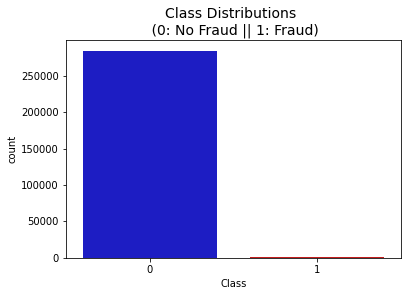

In [8]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# 2. 데이터 전처리

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [12]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [13]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [14]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# 3. 랜덤 UnderSampling and Oversampling

## 3.1 Distributing and Correlating

In [15]:
# Random Under Sampling

# 특정 비율(fraction)으로 무작위 표본 추출

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

print(new_df.shape)

new_df.head()

(984, 31)


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
121,-0.179976,-0.994079,-0.427191,0.745708,1.761811,-0.165130,0.058298,-0.213413,0.647323,0.073464,-0.291864,0.064800,1.527192,-0.131506,-1.696914,0.482121,0.586418,0.034541,-0.306278,-0.206030,-0.118939,0.052828,-0.201681,-0.432070,0.013164,0.161606,-0.401310,0.047423,0.102549,-0.116571,0
248296,-0.307413,0.812780,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,4.436319,-4.503801,-0.954361,-9.861372,-0.505329,0.269282,0.591319,1.795992,-1.085208,0.354773,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1
239,-0.027947,-0.993104,1.171439,0.474974,0.011761,1.264303,0.116234,-0.865986,0.554393,-0.276375,-0.471302,0.029104,0.252013,0.740676,0.588884,0.480297,0.799412,-0.592090,0.032839,-1.012363,-0.799293,-0.119439,0.070051,0.278843,-0.097491,0.426278,0.744938,-0.274728,0.008472,0.015492,0
239501,3.007895,0.768888,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,-0.448794,-2.562602,0.243483,-1.181669,0.004373,-2.302596,-4.446192,-1.710463,0.982729,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1
143336,3.226717,0.006967,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,-8.537758,6.348979,-8.681609,0.251179,-11.608002,-0.351569,-5.363566,-11.939092,-3.583603,0.897402,0.135711,0.954272,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,1


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


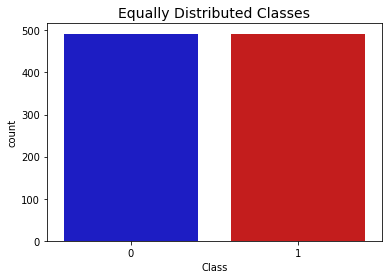

In [16]:
# DataFrame 균형이 맞춰짐.

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

* 요약 및 설명:
  * 음의 상관 관계: V17, V14, V12 및 V10은 음의 상관 관계입니다. 이 값이 낮을수록 최종 결과는 부정 거래일 가능성이 높아집니다.
  * 양의 상관 관계: V2, V4, V11 및 V19는 양의 상관 관계입니다. 이 값이 높을수록 최종 결과는 부정 거래일 가능성이 높아집니다.
  * Box plot : 우리는 사기 트랜잭션과 비사기 트랜잭션에서 이러한 특징의 분포를 더 잘 이해하기 위해 상자 그림을 사용할 것이다.
* 참고: 우리는 상관 행렬에 하위 표본을 사용해야 합니다. 그렇지 않으면 상관 행렬이 클래스 간의 높은 불균형에 의해 영향을 받을 것입니다. 
  * (이는 원본 데이터 프레임의 클래스 불균형이 높기 때문에 발생합니다.)

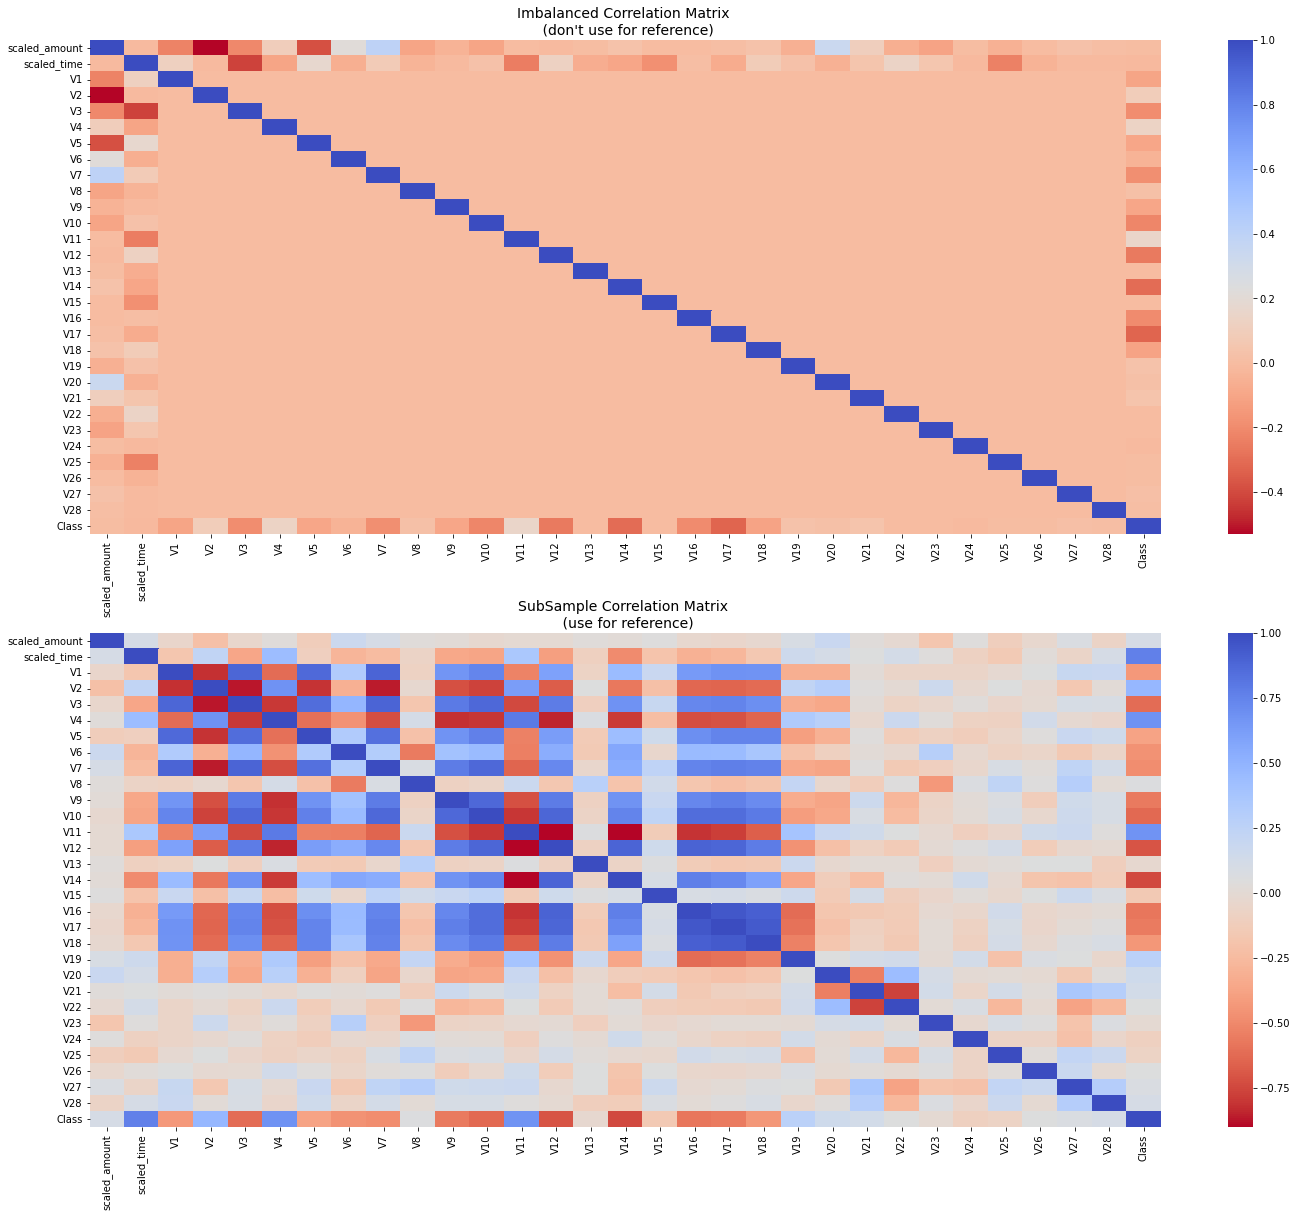

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

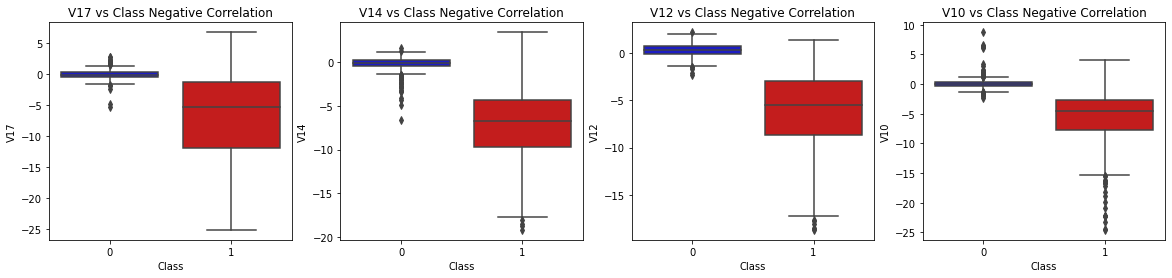

In [18]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

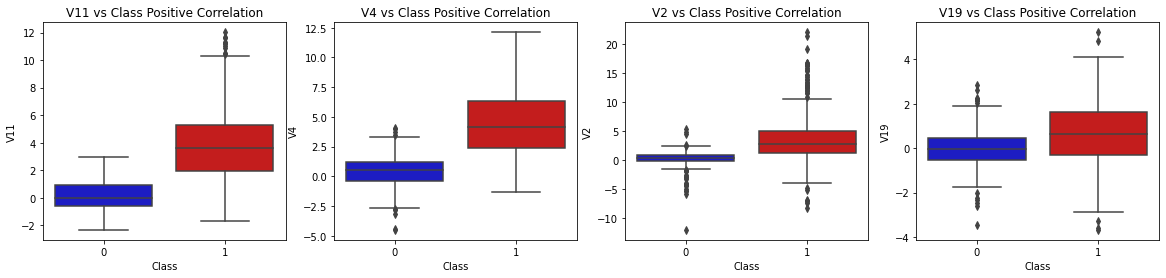

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## 3-2 Anomaly Detection

이상감지에서 주요 목표는 클래스와의 상관관계가 높은 변수에서 'outlier'를 제거하는 것이다. 이것은 모델 정확성에 긍정적인 영향을 미친다.

* 사분위간 범위 방법:
    * 사분위간 범위(IQR): 75번째 백분위수와 25번째 백분위수의 차이로 계산한다. 목표는 75번째 및 25번째 백분위수 이상의 임계값을 만드는 것이며, 어떤 인스턴스가 이 임계값을 통과할 경우 인스턴스가 삭제될 것이다.
    * 상자 그림: 25번째 백분위수와 75번째 백분위수(양쪽 끝)를 쉽게 볼 수 있을 뿐만 아니라 특이치(하한과 높은 극단값을 초과하는 점)도 쉽게 볼 수 있습니다.
    * 특이치 제거 트레이드오프 특이치를 제거하기 위한 임계값은 어디까지로 지정할지 주의해야 한다. 숫자(예: 1.5)에 사분위간 범위(사분위간 범위)를 곱하여 임계값을 결정한다. 이 임계값이 높을수록 특이치가 더 적게 탐지되고(더 높은 수의 ex: 3) 이 임계값은 더 많은 특이치를 탐지합니다.

* 트레이드오프 : 그러나 문턱값이 낮을수록 특이치가 더 많이 제거되기 때문에 특이치보다는 "극한 특이치"에 더 초점을 맞추려고 한다. 그 이유는 모형의 정확도가 낮아지는 정보 손실 위험을 실행할 수 있기 때문이다. 이 임계값을 사용하여 분류 모델의 정확도에 어떤 영향을 미치는지 확인할 수 있다.

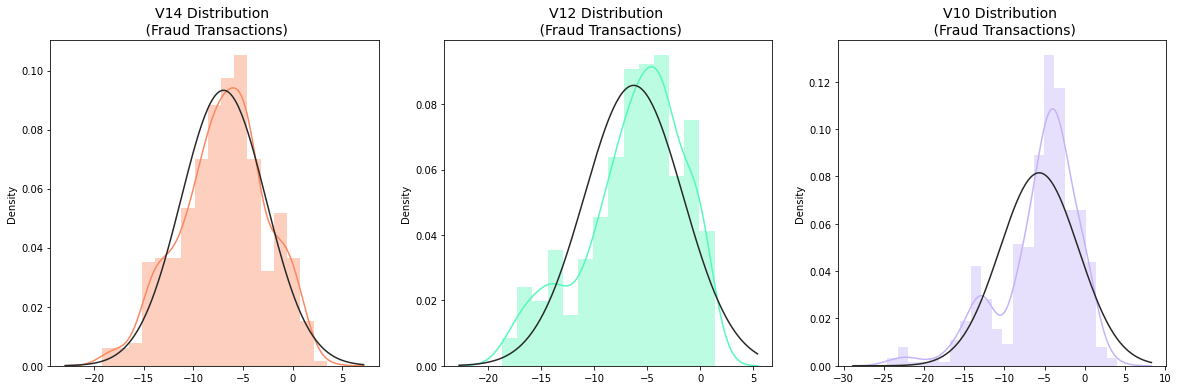

In [20]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

* 요약 : 
  * 분포 시각화: 먼저 일부 특이치를 제거하기 위해 사용할 기능의 분포를 시각화합니다. V12 및 V10에 비해 가우스 분포가 있는 기능은 V14가 유일합니다.
  * 임계값 결정: iqr에 곱하기 위해 사용할 숫자(이상치가 낮을수록 제거됨)를 결정한 후 q25 - 임계값(극한 하한)을 소산하고 q75 + 임계값(극한 상한)을 추가하여 상한 및 하한 임계값을 결정합니다.
  * 조건부 삭제: 마지막으로, "임계값"이 양 극단에서 모두 초과되면 인스턴스가 제거된다는 것을 나타내는 조건부 삭제 기능을 만듭니다.
  * 상자 그림 표현: 상자 그림을 통해 "극단 특이치"의 수가 상당한 양으로 감소했음을 시각화합니다.

In [21]:
# # -----> V14 특이치 제거하기 (가장 높은 Negative 상관 행렬을 가진 변수)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 특이치 제거하기
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# V10 특이치 제거하기 
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

# 참고: 이상값 감소를 구현한 후 정확도가 3% 이상 향상되었습니다! 
# 일부 특이치는 모델의 정확도를 왜곡할 수 있지만, 우리는 과도한 양의 정보 손실을 방지해야 한다.
# 그렇지 않으면 모델이 과소 적합될 위험이 있다.

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.049997689859396]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.683714633344298, -18.4311310279993, -18.047596570821604, -18.553697009645802]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-18.2711681738888, -

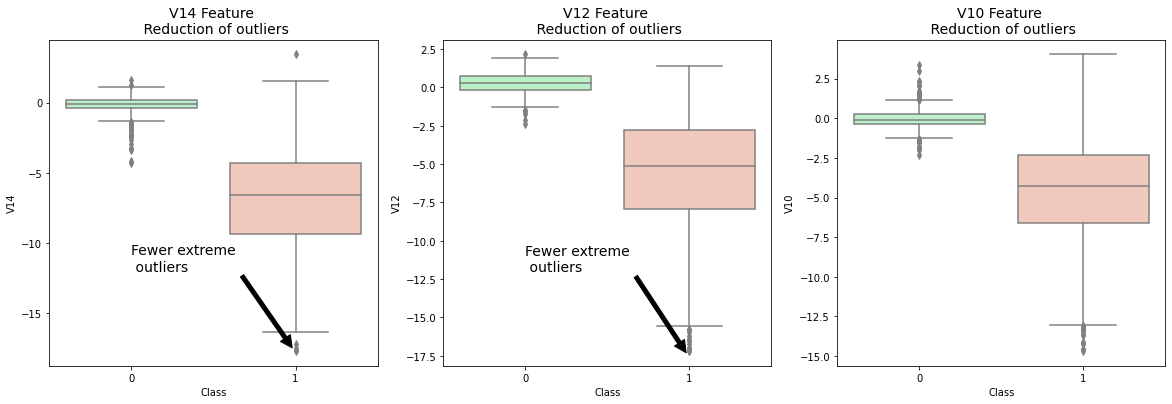

In [22]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## 3-3 Dimensionality Reduction and Clustering (t-SNE)

* t-SNE는 각 데이터 포인트를 2차원에 무작위로 표현한 후 원본 특성 공간에서 가가운 포인트는 가깝게, 멀리 떨어진 포인트는 멀어지게 만든다. 즉, 이웃 데이터 포인트에 대한 정보를 보존하려고 노력함.
* t-SNE 알고리즘을 이해하려면 다음 용어를 이해해야 한다.
    * 유클리드 거리
    * 조건부 확률
    * 정규 분포도 및 T 분포도

* 요약:
  * 데이터 세트에서 사기 및 비 사기 사례를 매우 정확하게 클러스터링할 수 있습니다.
  *  비록, 하위 샘플은 매우 작지만 t-SNE 알고리즘은 모든 시나리오에서 클러스터를 매우 정확하게 감지할 수 있습니다(t-SNE를 실행하기 전에 데이터 세트를 섞습니다)
  *  이는 추가 예측 모델이 사기 사례와 비 사기 사례를 구분하는 데 꽤 잘 수행될 것임을 시사합니다.

In [24]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 6.2 s
PCA took 0.024 s
Truncated SVD took 0.011 s


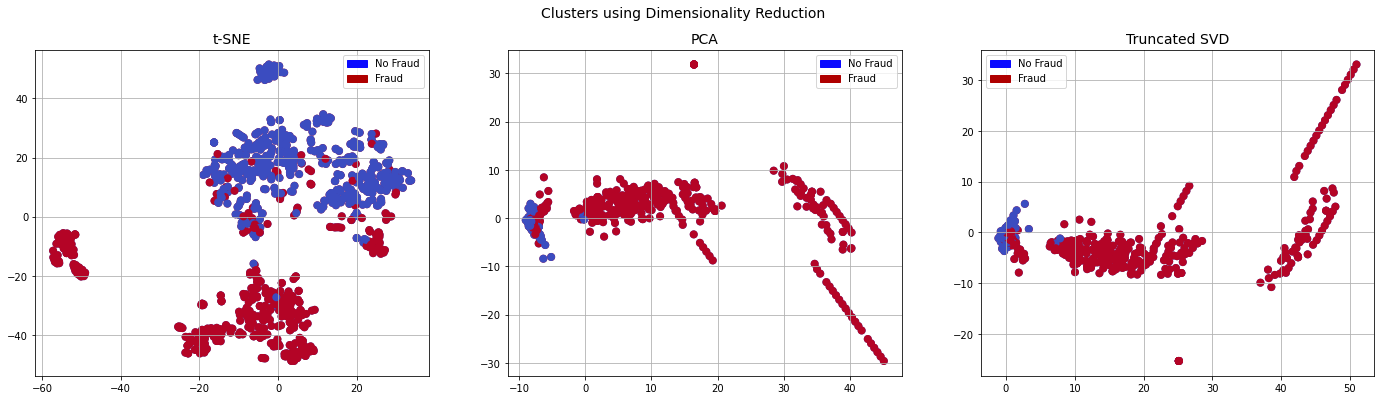

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## 3-4 Classifiers(분류)


* 분류기(UnderSampling):
  * 이 섹션에서는 4가지 유형의 분류기를 훈련하고 어떤 분류기가 사기 거래를 탐지하는 데 더 효과적인지 결정할 것입니다. 
  * 그 전에 데이터를 훈련 세트와 테스트 세트로 분할하고 레이블에서 기능을 분리해야 한다.

* 요약:
  * 로지스틱 회귀 분류기 : 대부분의 경우 다른 세 Classifier 보다 정확하다. (로지스틱 회귀 분석 추가)
  * GridSearchCV : Classifier 대해 최상의 예측 점수를 제공하는 매개 변수를 결정하는 데 사용된다.
  * 로지스틱 회귀 분석에서는 가장 좋은 ROC(수신 작동 특성 점수)가 있다. 이 ROC 기법은 로지스틱 회귀 분석에서는 부정 행위와 부정 행위 이외의 트랜잭션을 상당히 정확하게 구분한다.

* 참고:
  * training score와 cross validation score의 간격이 넓을수록 모형이 과대 적합될 가능성이 높습니다 (고분산).
  * training score와 cross validation score 모두 점수가 낮은 경우 과소 적합할 가능성이 높다.(높은 편향).
  * 로지스틱 회귀 분석 Classifier 는 train 세트와 cross validate 세트 모두에서 가장 높은 점수를 표시합니다.

In [27]:
# 교차 검증 전 언더샘플링(과적합이 발생하기 쉬움)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# 분류 알고리즘을 제공하기 위해 값을 배열로 바꿉니다.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [29]:
# 교차 검증을 적용해도 점수가 더 올라간다.
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 96.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


In [30]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [31]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  99.34%
Knears Neighbors Cross Validation Score 94.97%
Support Vector Classifier Cross Validation Score 99.47%
DecisionTree Classifier Cross Validation Score 99.87%


In [32]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [33]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

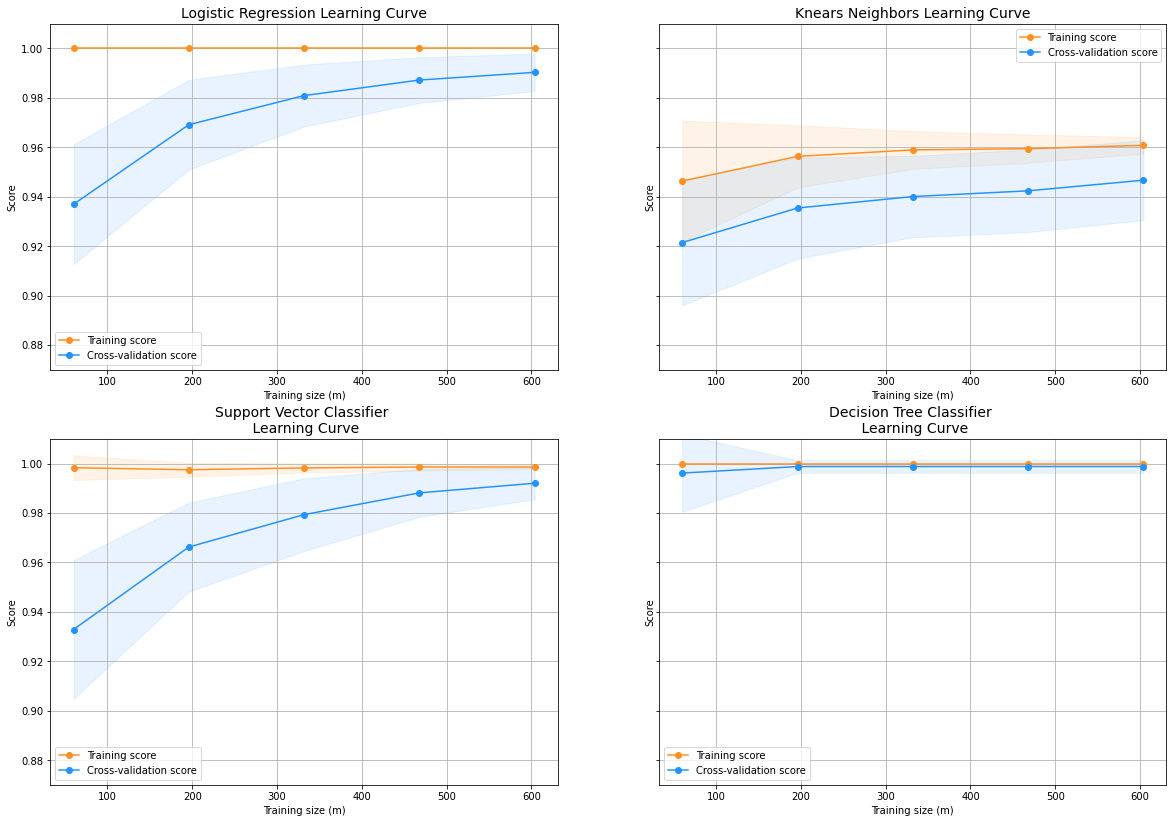

In [34]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

# training size가 커지면 커질수록 trainig score, cross-valication score는 비슷해져간다.

In [35]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [36]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9994523087293563
KNears Neighbors:  0.9487698011459387
Support Vector Classifier:  0.9997753061453769
Decision Tree Classifier:  0.9986413043478262


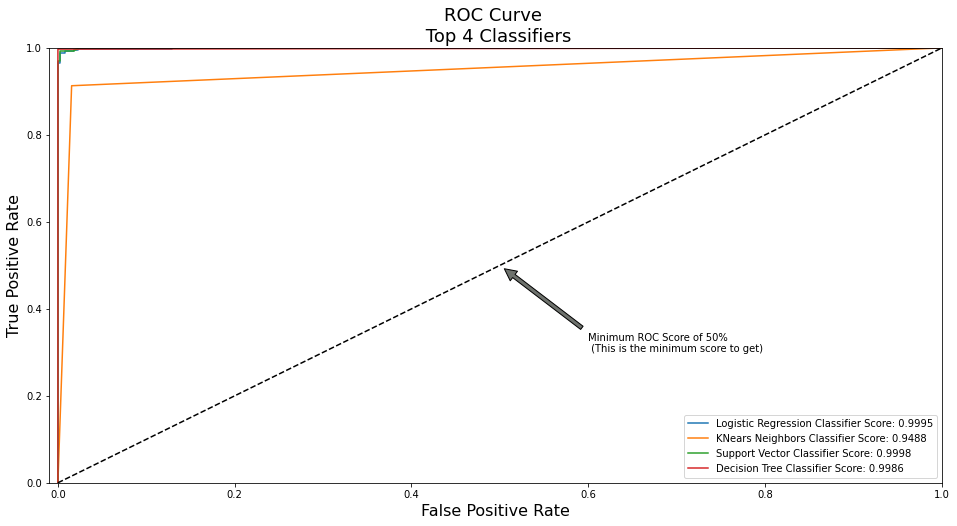

In [37]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## 3-5 Logistic Regression

* Terms:
  * True Positives: Correctly Classified Fraud Transactions
  * False Positives: Incorrectly Classified Fraud Transactions
  * True Negative: Correctly Classified Non-Fraud Transactions
  * False Negative: Incorrectly Classified Non-Fraud Transactions
  * Precision: True Positives/(True Positives + False Positives)

* Recall: True Positives/(True Positives + False Negatives)
  * Precision은 사기 거래를 탐지하는 데 있어 모델이 얼마나 정확한지(얼마나 확실한지) / 모델이 탐지할 수 있는 사기 사건의 양입니다.
  * Precision/Recall Tradeoff: 우리 모델이 더 정확할수록(선택적) 검출되는 사례가 적어진다.

* Summary:
  * 정밀도(Precision)은 0.90~0.91 사이에서 감소하기 시작한다. 우리의 정밀도 점수는 여전히 높고, 재현율 점수도 감소하고 있다.

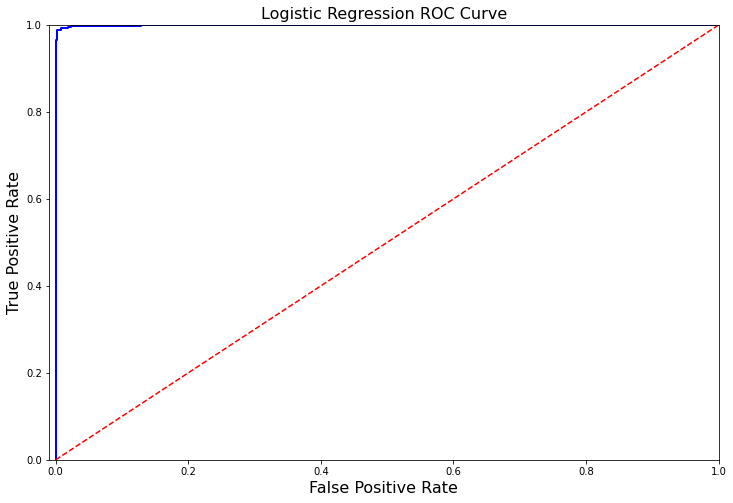

In [39]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [40]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [41]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.95
Precision Score: 0.63
F1 Score: 0.76
Accuracy Score: 0.70
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.46
Precision Score: 0.00
Recall Score: 0.96
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


In [42]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [43]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.01


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.01')

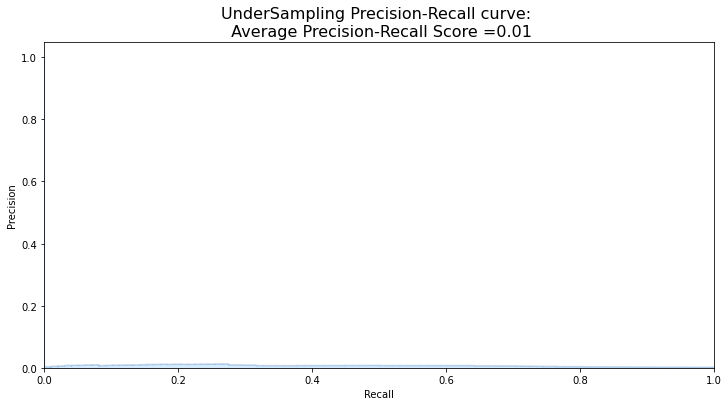

In [44]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

## 3-6 SMOTE와 Oversampling

SMOTE : minor class의 instance를 단순하게 복제함으로써 생기는 overfitting을 피하기 위해 사용된다. 소수 클래스로부터 data의 subset을 뽑아낸 다음에 새롭게 비슷한 instance를 생성한다. 이 새롭게 만든 인스턴스들은 원래 dataset에 더해지고 train set으로 사용된다.

* 장점:
  * synthetic example은 random하게 oversampling하는 것보다 overfitting이 일어날 가능성이 줄어든다.
정보가 손실될 우려가 없다. 
* 단점:
  * SMOTE는 minor class의 synthetic data를 생성하는 동안 인접해있는 major class의 instance들의 위치는 고려하지 않는다. 그래서 클래스가 겹치거나 노이즈를 만들 수 있다.
  * SMOTE는 고차원 데이터에 효율적이지 않다.
  * 언더샘플링보다 정확할 가능성이 높지만 행이 제거되지 않기 때문에 훈련하는 데 더 많은 시간이 걸릴 것이다.

In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters

# 'newton-cg', 'lbfgs', 'sag' 및 'saga'는 L2를 처리하거나 페널티 없음
# 'liblinear' 및 'saga'도 L1 패널티를 처리합니다.

log_reg_params = {"penalty": ['l1', 'l2'], "solver" : ['saga'],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9405438317639423
precision: 0.05665083577729073
recall: 0.9162934112301201
f1: 0.10512320862335359
---------------------------------------------------------------------------------------------------------------------------------------


In [49]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56863
       Fraud       0.06      0.87      0.11        98

    accuracy                           0.98     56961
   macro avg       0.53      0.92      0.55     56961
weighted avg       1.00      0.98      0.99     56961



In [50]:
y_score = best_est.decision_function(original_Xtest)

In [51]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.69


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.69')

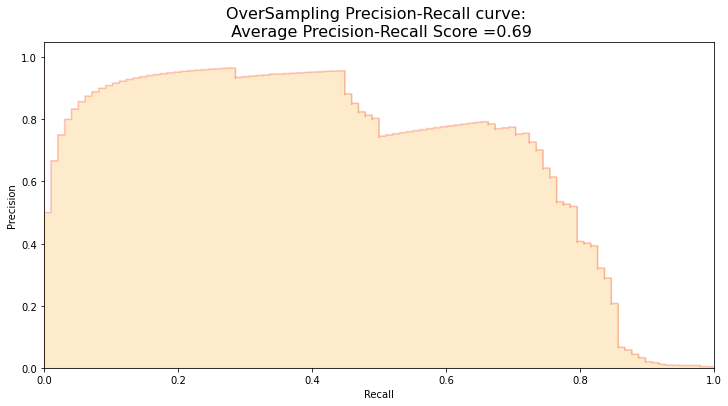

In [52]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [53]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [54]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :9.400341033935547 sec


# 4. 테스팅

## 4.1 로지스틱 회귀 테스트

* 랜덤 undersampling: 우리는 랜덤 undersampling subset에서 분류모델의 마지막 성능평가할 것이다. 하지만 이것은 original dataframe으로 부터의 데이터가 아님을 명심하라.
* 분류 모델 : 가장 성능이 좋은 모델은 logistic regression과 SVC(Support Vector Classifier) 였다.

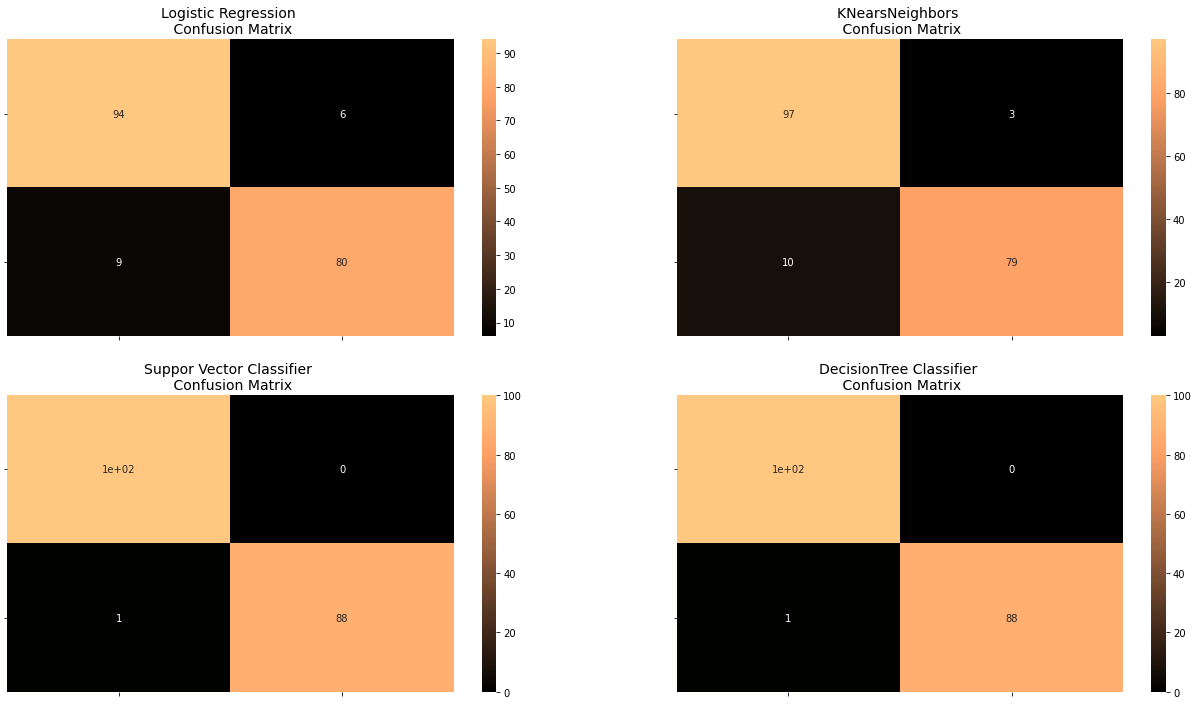

In [55]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [56]:

from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       100
           1       0.93      0.90      0.91        89

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       100
           1       0.96      0.89      0.92        89

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99        89

    accuracy                           0.99       189
   macro avg       1.00      0.99      0.99       189
weighted

In [57]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

# 점수를 비교한 결과, SMOTE 기법을 적용한 Oversampling 기법이 score가 더 높게 나왔다.

,Technique,Score
0,Random UnderSampling,0.920635
1,Oversampling (SMOTE),0.975966


## 4-2 신경망 테스트

* 이 섹션에서는 UnderSample 또는 OverSample(SMOTE)를 구현한 두가지 Logistic Regression 모델 중 Fraud, Non-Fraud를 탐지하는데 더 나은 모델을 확인하기 위해 간단한 신경망 모델을 구현한다.
* 우리는 Fraud 데이터에 집중하지 않고 Non-Fraud 거래에 중점을 둘 것이다. 왜냐하면 카드 소지자가 물건을 구입한 후 은행의 알고리즘에 의해 카드가 막혔다고 하면 안되기 때문이다.
* 신경망 구조(Neural Network Structure)

* 32개의 노드를 가진 hidden layer 구성
  * outnode는 2개(0 혹은 1)
  * learning late : 0.001
  * optimizer : AdamOptimizer
  * activation function : Relu
  * final output은 sparse categorical cross entropy 적용
    * 이것은 결과가 Fraud, Non-Fraud의 확률을 제공함.

Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):

* Keras, Random UnderSampling

In [58]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [59]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [60]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 1s - loss: 1.1599 - accuracy: 0.6076 - val_loss: 0.4817 - val_accuracy: 0.8212
Epoch 2/20
25/25 - 0s - loss: 0.3652 - accuracy: 0.9007 - val_loss: 0.2817 - val_accuracy: 0.9073
Epoch 3/20
25/25 - 0s - loss: 0.2313 - accuracy: 0.9421 - val_loss: 0.2140 - val_accuracy: 0.9404
Epoch 4/20
25/25 - 0s - loss: 0.1711 - accuracy: 0.9536 - val_loss: 0.1736 - val_accuracy: 0.9404
Epoch 5/20
25/25 - 0s - loss: 0.1366 - accuracy: 0.9586 - val_loss: 0.1456 - val_accuracy: 0.9470
Epoch 6/20
25/25 - 0s - loss: 0.1150 - accuracy: 0.9636 - val_loss: 0.1300 - val_accuracy: 0.9470
Epoch 7/20
25/25 - 0s - loss: 0.1008 - accuracy: 0.9685 - val_loss: 0.1187 - val_accuracy: 0.9536
Epoch 8/20
25/25 - 0s - loss: 0.0891 - accuracy: 0.9685 - val_loss: 0.1137 - val_accuracy: 0.9603
Epoch 9/20
25/25 - 0s - loss: 0.0791 - accuracy: 0.9719 - val_loss: 0.1038 - val_accuracy: 0.9603
Epoch 10/20
25/25 - 0s - loss: 0.0709 - accuracy: 0.9735 - val_loss: 0.0995 - val_accuracy: 0.9669
Epoch 11/20
25/25 -

In [62]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [64]:
# np.argmax(model.predict(x_test), axis=-1)

undersample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest, batch_size=200, verbose=0),axis=-1)

In [65]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[13901 42962]
 [    0    98]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


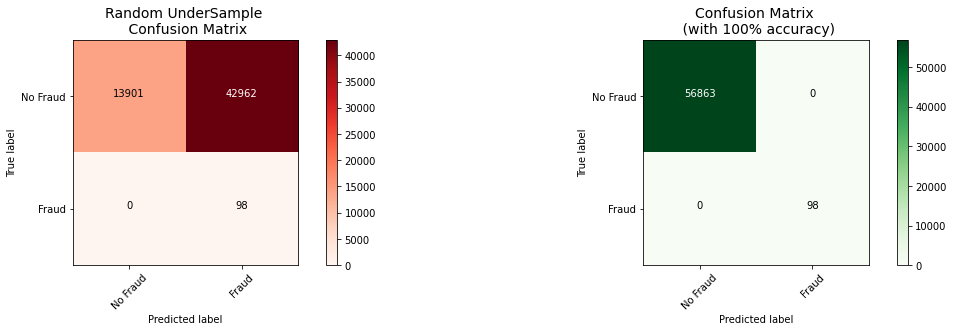

In [66]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

* Keras, OverSampling (SMOTE):

In [67]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [68]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [69]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 2s - loss: 0.0676 - accuracy: 0.9768 - val_loss: 0.0178 - val_accuracy: 0.9939
Epoch 2/20
1214/1214 - 2s - loss: 0.0118 - accuracy: 0.9976 - val_loss: 0.0079 - val_accuracy: 0.9995
Epoch 3/20
1214/1214 - 2s - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 4/20
1214/1214 - 2s - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/20
1214/1214 - 2s - loss: 0.0038 - accuracy: 0.9992 - val_loss: 5.9893e-04 - val_accuracy: 1.0000
Epoch 6/20
1214/1214 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9998
Epoch 7/20
1214/1214 - 2s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9998
Epoch 8/20
1214/1214 - 2s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 9/20
1214/1214 - 2s - loss: 0.0022 - accuracy: 0.9995 - val_loss: 9.4012e-04 - val_accuracy: 1.0000
Epoch 10/20
1214/1214 - 2s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 8

In [70]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [72]:
# np.argmax(model.predict(x_test), axis=-1)

oversample_fraud_predictions = np.argmax(oversample_model.predict(original_Xtest, batch_size=200, verbose=0),axis=-1)

Confusion matrix, without normalization
[[56850    13]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


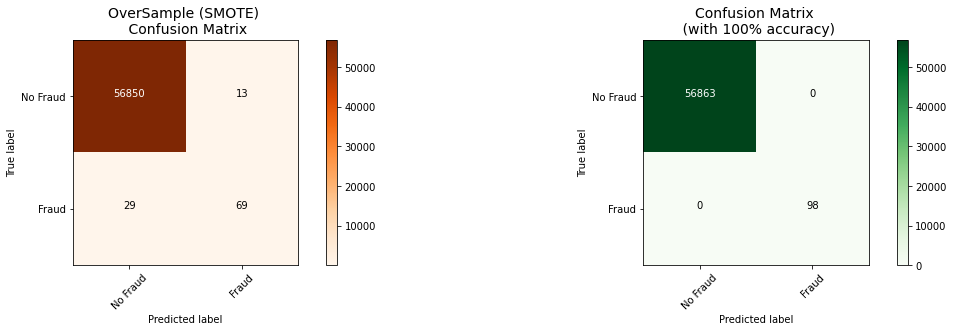

In [73]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

* 결론:

  * 불균형 데이터 세트에 SMOTE를 구현하면 레이블의 불균형을 해결할 수 있었다.
  * 때때로 OverSampling data set를 사용한 신경망은 UnderSampling data set를 사용하는 모델보다 덜 정확한 Fraud를 예측한다.
  * 그러나 특이치 제거는 OverSampling된 데이터 집합이 아니라 Random UnderSampling 데이터에서만 실행해야한다.
  * 또한, UnderSampling 데이터를 사용한 모델에서는 많은 수의 Non-Fraud 트랜잭션에 대해 정확하게 감지 할수 없다. Non-Fraud 거래 또한, Fraud 거래로 잘못 분류할 수 있다.